In [1]:
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

MATRIX_FILE = "training_data/A549/noNNN/ENCFF045PYX_rep5_all_matrix.tsv"
NUM_TRUE_LABELS = 72082
COEFF_OUTPUT = "training_data/A549/noNNN/rep5_coeff.tsv"
CELL_TYPE = "A549"
REP = "rep5noNNN"

PLOT_1_TITLE = CELL_TYPE + " " + REP + " LogisticReg, auc "
PLOT_1_OUTPUT = CELL_TYPE + "_" + REP + "_roc.png"
PLOT_CV_TITLE = CELL_TYPE + " " + REP + " LogisticRegCV, auc "
PLOT_CV_OUTPUT = CELL_TYPE + "_" + REP + "_roc_CV.png"

In [2]:
"""
Return training set and test set for training the classifier.
in: string matrix_filename
    int num_true_labels
out: np.array X_train, y_train, X_test_, y_test
"""
def get_matrices(matrix_filename, num_true_labels):
    
    X_raw = np.loadtxt(matrix_filename, delimiter='\t')
    X_size = X_raw.shape[0]
    
    if num_true_labels == -1:
        num_true_labels = X_size/2
    
    y = np.zeros((X_size,), dtype=np.uint8)
    
    shuffle_ids = np.random.permutation(X_size)
    
    for i in range(num_true_labels):
        y[i] = 1
    
#     X = normalize(X_raw)
    X = X_raw
    X = X[shuffle_ids]
    y = y[shuffle_ids]
    
    X_train = X[:X_size/2]
    y_train = y[:X_size/2]

    X_test = X[X_size/2:]
    y_test = y[X_size/2:]
    
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = get_matrices(MATRIX_FILE, NUM_TRUE_LABELS)

lr = LogisticRegression(C=1.0)
lr.fit(X_train, y_train)
results = lr.predict(X_test)

In [4]:
diff = results - y_test
total = 0
false_p = 0
false_n = 0
for i in diff:
    if i == 255:
        false_n += 1
        total += 1
    if i == 1:
        false_p += 1
        total += i

print "Training set score =", lr.score(X_train, y_train)
print "Test set score =", lr.score(X_test, y_test)
X_size = X_test.shape[0]*2
print "False rate =", float(total)/(X_size/2)
print "False positive rate =", float(false_p)/(X_size/2)
print "False negative rate =",float(false_n)/(X_size/2)

Training set score = 0.873236609703
Test set score = 0.869496652474
False rate = 0.130503347526
False positive rate = 0.0567574154517
False negative rate = 0.0737459320746


In [5]:
coefs = lr.coef_
motif_list = pd.read_csv("human_pwm_ids_sorted.txt", sep=' ', header=None)
sort_ids = np.flip(np.argsort(coefs), 1)
motif_list['coeff'] = coefs.T

save_results = motif_list.iloc[sort_ids[0], [1,2,3]]
# save_results.to_csv(COEFF_OUTPUT, sep='\t')

In [6]:
y_score = lr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
auc = roc_auc_score(y_test, y_score[:, 1])

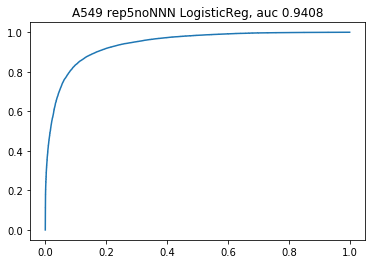

In [7]:
plt.plot(fpr, tpr)
PLOT_1_TITLE = PLOT_1_TITLE + "%.4f" %auc
plt.title(PLOT_1_TITLE)
# plt.savefig(PLOT_1_OUTPUT)
plt.show()

In [ ]:
clfcv = LogisticRegressionCV(cv=5)
clfcv.fit(X_train, y_train)
print "Score:", clfcv.score(X_test, y_test)

y_score = clfcv.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])

In [ ]:
auc = roc_auc_score(y_test, y_score[:, 1])

plt.plot(fpr, tpr)
PLOT_CV_TITLE = PLOT_CV_TITLE + "%.4f" %auc
plt.title(PLOT_CV_TITLE)
plt.savefig(PLOT_CV_OUTPUT)
plt.show()

In [ ]:
clfcv.C_